In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config

import lsst.afw.table
import lsst.meas.algorithms
import lsst.pex.exceptions
import lsst.meas.extensions.gaap

In [2]:
from astropy.io import fits
import sys
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts/')

get existing patches

In [3]:
import os

In [4]:
old_patches = [name for name in os.listdir(
    "/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/")]
new_patches = [int(name[0]) + int(name[2]) * 9 for name in old_patches]
merian_patches = [int(name) for name in os.listdir(
    "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_forced_src/9813")]
common_patches = np.intersect1d(new_patches, merian_patches)

In [5]:
common_patches

array([ 0,  1,  2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19,
       20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38,
       39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 79])

In [6]:
np.where(np.array(common_patches) == 32)

(array([28]),)

In [48]:
from hsc_gaap.gaap import GaapTask
gaap = GaapTask(9813, 32, 'i', 
                repo='/projects/MERIAN/repo/', 
                collections='S20A/deepCoadd_calexp')
gaap._checkHSCfile()
gaap.load_merian_reference(band='N708', 
                           repo='/projects/MERIAN/repo/', 
                           collections='DECam/runs/merian/dr1_wide',
                           range=(0, 8000)
                          )
gaap.setDefaultMeasureConfig()
gaap.run()
outcat = gaap.writeObjectTable()

Loaded HSC deepCoadd_calexp image
Loaded Merian reference catalog and image
# Starting the GAaP measureTask at  Mon Nov  7 19:41:48 2022


Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_3 because could not find ext_gaap_GaapFlux_1_15x_0_3_instFlux or ext_gaap_GaapFlux_1_15x_0_3_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_4 because could not find ext_gaap_GaapFlux_1_15x_0_4_instFlux or ext_gaap_GaapFlux_1_15x_0_4_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_5 because could not find ext_gaap_GaapFlux_1_15x_0_5_instFlux or ext_gaap_GaapFlux_1_15x_0_5_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_6 because could not find ext_gaap_GaapFlux_1_15x_0_6_instFlux or ext_gaap_GaapFlux_1_15x_0_6_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_7 because could not find ext_gaap_GaapFlux_1_15x_0_7_instFlux or ext_gaap_GaapFlux_1_15x_0_7_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_1_0 because could not find ext_gaap_GaapFlux_1_15x_1_0_instFlux or ext_gaap_GaapFlux_1_15x_1_0_instFluxErr in ap

# Finished the GAaP measureTask in 353.33 seconds.
Wrote GAaP table to /projects/MERIAN/repo/S20A/gaapTable/9813/5,3/gaapTable_I_9813_5,3.fits


In [71]:
outcat = gaap.writeObjectTable()

Wrote GAaP table to /projects/MERIAN/repo/S20A/gaapTable/9813/5,3/gaapTable_I_9813_5,3.fits


[]

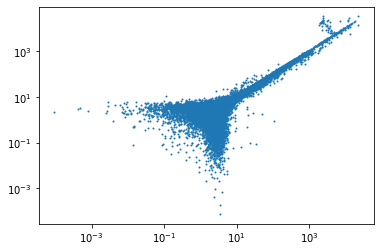

In [31]:
plt.scatter(gaap.measCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], 
            gaap.refCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], s=1)

plt.loglog()

In [72]:
good_objects = ~(outcat["i_gaap_flag"] | outcat['i_gaapOptimalFlux_flag_bigPsf'])
np.sum(good_objects), len(good_objects)

(3713, 8000)

/tmp/ipykernel_14524/1507045082.py:13: RuntimeWarning: invalid value encountered in true_divide
  snr = gaap.measCat[baseName+"_instFlux"][good_objects] / gaap.measCat[baseName+"_instFluxErr"][good_objects]


Text(0.5, 0, 'Sigmas')

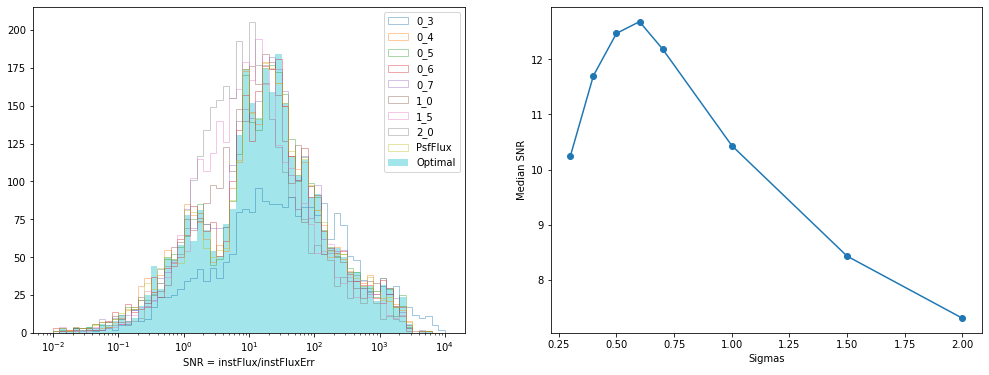

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(17,6))
bins = np.logspace(-2,4,61)

baseNames = list(gaap.measureConfig.measurement.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"))
statistic_list = []
statistic_upper_list, statistic_lower_list = [], []

for baseName in gaap.measureConfig.measurement.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
    label = baseName.split("x_")[-1]
    #if label[-1]=='5': continue
#     if "PsfFlux" in label: continue
    histtype='stepfilled' if "Optimal" in baseName else 'step'
    snr = gaap.measCat[baseName+"_instFlux"][good_objects] / gaap.measCat[baseName+"_instFluxErr"][good_objects]
    ax[0].hist(snr, bins=bins, histtype=histtype,label=label, alpha=0.4)
    statistic = np.nanpercentile(snr, 50)
    # statistic = np.nanmean(snr)
    if "Optimal" in label:
        optStatistic = np.nanpercentile(snr, 50)
    if not ("PsfFlux" in label or "Optimal" in label):
        statistic_list.append(statistic)
        statistic_upper_list.append(np.percentile(snr, 84))
        statistic_lower_list.append(np.percentile(snr, 16))

ax[0].set_xscale('log')
ax[0].set_xlabel("SNR = instFlux/instFluxErr")
#ax[0].set_yscale('log')
ax[0].legend(loc='best')

sigmas = gaap.measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas.list()
ax[1].plot(sigmas, statistic_list, 'o-')
#ax[1].fill_between(sigmas, statistic_upper_list, statistic_lower_list, alpha=0.4)
# ax[1].plot(3.6, optStatistic, "*", markersize=12)
ax[1].set_ylabel("Median SNR")
ax[1].set_xlabel("Sigmas")
# ax[1].axvline(3.5, color='k', ls='-.')

In [76]:
measureConfig = gaap.measureConfig.measurement

In [80]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom

In [116]:
np.where(gaap.measCat['id'] == 3495941200978922344)

(array([7326]),)

In [124]:
np.where(good_objects)[0][:30]

array([ 0,  1,  3,  4,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 19, 20,
       21, 22, 24, 27, 28, 31, 32, 36, 37, 38, 39, 41, 44])

Text(0.5, 1.0, 'recordId = 44')

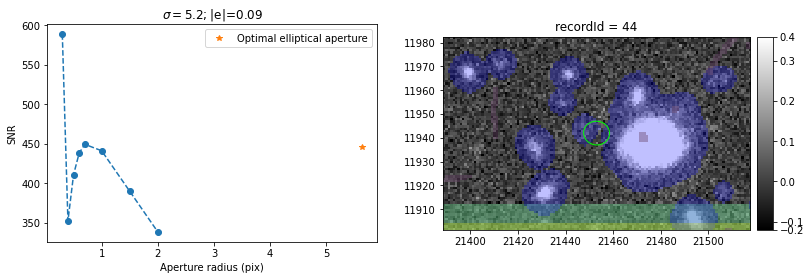

In [127]:
recordId = 44
scalingFactor = 1.15

def printShape(shape):
    ixx, iyy, ixy = shape.getParameterVector()
    det = shape.getDeterminantRadius()
    complex_ellip = ((ixx-iyy)+1j*2*ixy)/(ixx+iyy)
    ellip = np.hypot(complex_ellip.real, complex_ellip.imag)
    # return f"Quad(ixx={ixx:.2f}, iyy={iyy:.2f}, ixy={ixy:.2f}); det={det:.1f}; |e|={ellip:.2f}"
    return rf"$\sigma = ${det:.1f}; |e|={ellip:.2f}"

printShape(shape)

def getSnr(sigmas):
    for sigma in sigmas:
        baseName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(scalingFactor, sigma, "ext_gaap_GaapFlux")
        snr = gaap.measCat[recordId][baseName+"_instFlux"]/gaap.measCat[recordId][baseName+"_instFluxErr"]
        yield snr
        
sigmas = np.array(measureConfig.plugins["ext_gaap_GaapFlux"].sigmas)
snrs = np.array(list(getSnr(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].plot(sigmas[snrs>0], snrs[snrs>0], 'o--')

shape = gaap.measCat[recordId].getShape()
optShape = afwGeom.Quadrupole(gaap.measCat[recordId]["ext_gaap_GaapFlux_OptimalShape_xx"],
                              gaap.measCat[recordId]["ext_gaap_GaapFlux_OptimalShape_yy"],
                              gaap.measCat[recordId]["ext_gaap_GaapFlux_OptimalShape_xy"],)
sigma = optShape.getDeterminantRadius()
snr = list(getSnr(("Optimal",)))[0]
ax[0].plot(sigma, snr, '*', label='Optimal elliptical aperture')

ax[0].set_ylabel("SNR")
ax[0].set_xlabel("Aperture radius (pix)")
ax[0].set_title(printShape(shape))
#plt.yscale('log')
ax[0].legend(loc='best')


afwDisplay.setDefaultBackend('matplotlib')
plt.sca(ax[1])
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
# display.setMaskTransparency(100)
footprint = gaap.refCat[recordId].getFootprint()
bbox = footprint.getBBox()
cutout = gaap.exposure[bbox]
display.mtv(cutout)
display.dot(shape, *bbox.getCenter())
ax[1].set_title(f"recordId = {recordId}")

In [115]:
shape

Quadrupole(ixx=nan, iyy=nan, ixy=nan)